In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2

from tqdm import tqdm

import torch
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms

In [2]:
def add_noise(img, noise_type="gaussian", mean=0, var=1):
    row, col = 64, 64
    img = img.astype(np.float32)
    sigma = var ** .5

    if noise_type == "gaussian":
        noise = np.random.normal(mean, sigma, img.shape)
        noise = noise.reshape(row, col)
        img = img + noise
        return img

    if noise_type == "speckle":
        noise = np.random.gamma(mean, scale=sigma, size=img.shape)
        img = img * noise
        return img

def snr(img1, img2):
    sz = img1.shape
    acc_num = 0
    acc_den = 0

    for i in range(0, sz[0]):
        for j in range(0, sz[1]):
            acc_num += img1[i][j] ** 2
            acc_den += (img1[i][j] - img2[i][j]) ** 2

    return acc_num / acc_den

def psnr(img1, img2):
    sz = img1.shape
    acc_mse = 0

    for i in range(0, sz[0]):
        for j in range(0, sz[1]):
            acc_mse += (img1[i][j] - img2[i][j]) ** 2

    acc_mse /= (sz[0] * sz[1])

    return 10 * np.log(255 ** 2 / acc_mse)

def normalisation(X):
    minX = np.min(X)
    maxX = np.max(X)

    return (X - minX)/(maxX - minX)

In [3]:
data = []
imgs_path = "data"

kernel = np.ones((2,2),np.uint8)

for filename in os.listdir(imgs_path):
            f = os.path.join(imgs_path, filename)
            data.append(cv2.threshold(cv2.dilate(cv2.imread(f, 0), kernel), 20, 255, cv2.THRESH_BINARY)[1])

random.shuffle(data)

xtrain = data[:14000]
xtest = data[14000:]

noises = ["gaussian", "speckle"]
mean = 0
var = 10000.
lb = 1.1
a = lb
scale = 1 / (lb - 1)
noise_ct = 0
noise_id = 0
traindata = np.zeros((14000, 64, 64))

for idx in tqdm(range(len(xtrain))):
    traindata[idx] = add_noise(xtrain[idx], noise_type=noises[noise_id], mean=mean, var=var)


print("\n{} noise addition completed to images".format(noises[noise_id]))

testdata = np.zeros((956, 64, 64))

for idx in tqdm(range(len(xtest))):
    x = add_noise(xtest[idx], noise_type=noises[noise_id], mean=mean, var=var)
    testdata[idx] = x

print("\n{} noise addition completed to images".format(noises[noise_id]))

100%|██████████| 14000/14000 [00:01<00:00, 12871.65it/s]



gaussian noise addition completed to images


100%|██████████| 956/956 [00:00<00:00, 12893.89it/s]


gaussian noise addition completed to images


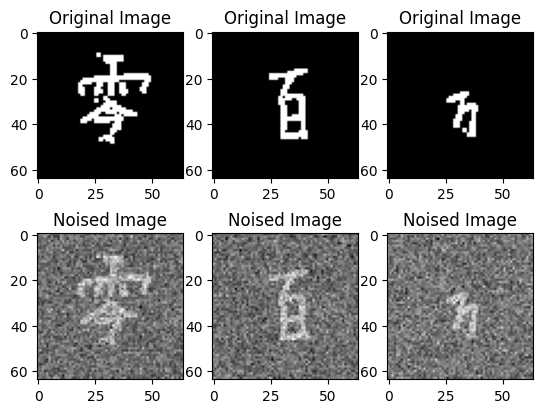

SNR:  0.6491200765084295
PSNR:  18.89176516441163


In [6]:
f, axes = plt.subplots(2, 3)

# showing images with gaussian noise
axes[0, 0].imshow(xtrain[0], cmap="gray")
axes[0, 0].set_title("Original Image")
axes[1, 0].imshow(traindata[0], cmap='gray')
axes[1, 0].set_title("Noised Image")

# showing images with gaussian noise
axes[0, 1].imshow(xtrain[5000], cmap="gray")
axes[0, 1].set_title("Original Image")
axes[1, 1].imshow(traindata[5000], cmap='gray')
axes[1, 1].set_title("Noised Image")

# showing images with speckle noise
axes[0, 2].imshow(xtrain[10000], cmap='gray')
axes[0, 2].set_title("Original Image")
axes[1, 2].imshow(traindata[10000], cmap="gray")
axes[1, 2].set_title("Noised Image")
plt.show()

snr_estim = snr(xtrain[0], traindata[0])
psnr_estim = psnr(xtrain[0], traindata[0])

print("SNR: ", snr_estim)
print("PSNR: ", psnr_estim)

In [14]:
class noisedDataset(Dataset):
    def __init__(self, datasetnoised, datasetclean, transform):
        self.noise = datasetnoised
        self.clean = datasetclean
        self.transform = transform

    def __len__(self):
        return len(self.noise)

    def __getitem__(self, idx):
        xNoise = self.noise[idx]
        xClean = self.clean[idx]

        if self.transform is not None:
            xNoise = self.transform(xNoise)
            xClean = self.transform(xClean)

        return xNoise, xClean

In [15]:
tsfms = transforms.Compose([transforms.ToTensor(), transforms.Resize((32, 32))])

trainset = noisedDataset(traindata, xtrain, tsfms)
testset = noisedDataset(testdata, xtest, tsfms)

batch_size = 32

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=1, shuffle=True)

In [41]:
from torch import nn

class denoising_model(nn.Module):
    def __init__(self):
        super(denoising_model, self).__init__()
        self.encoderDense = nn.Sequential(
            nn.Linear(32 * 32, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True)
        )

        self.decoderDense = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 32 * 32),
            nn.Sigmoid(),
        )

        self.encoderConv1D = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool1d(2),
            nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool1d(2),
            nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool1d(2),
            nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(True),
        )


        self.decoderConv1D = nn.Sequential(
            nn.ConvTranspose1d(in_channels=16, out_channels=32, kernel_size=3, output_padding=1, padding = 1, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose1d(in_channels=32, out_channels=64, kernel_size=3, output_padding=1, padding = 1, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose1d(in_channels=64, out_channels=128, kernel_size=3, output_padding=1, padding = 1, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose1d(in_channels=128, out_channels=1, padding=1, kernel_size=3),
            nn.Sigmoid(),
        )

        self.encoderConv2D = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(True),
        )


        self.decoderConv2D = nn.Sequential(
            nn.ConvTranspose2d(in_channels=16, out_channels=32, kernel_size=3, output_padding=1, padding = 1, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=32, out_channels=64, kernel_size=3, output_padding=1, padding = 1, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=3, output_padding=1, padding = 1, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=128, out_channels=1, padding=1, kernel_size=3),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoderConv2D(x)
        x = self.decoderConv2D(x)

        return x

In [42]:
from torchsummary import summary

model = denoising_model()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model.to(device)

summary(model, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 32, 32]           1,280
              ReLU-2          [-1, 128, 32, 32]               0
         MaxPool2d-3          [-1, 128, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          73,792
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7             [-1, 32, 8, 8]          18,464
              ReLU-8             [-1, 32, 8, 8]               0
         MaxPool2d-9             [-1, 32, 4, 4]               0
           Conv2d-10             [-1, 16, 4, 4]           4,624
             ReLU-11             [-1, 16, 4, 4]               0
  ConvTranspose2d-12             [-1, 32, 8, 8]           4,640
             ReLU-13             [-1, 32, 8, 8]               0
  ConvTranspose2d-14           [-1, 64,

In [43]:
if torch.cuda.is_available() == True:
    device = "cuda:0"
else:
    device = "cpu"

print(device)

model = denoising_model().to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-5)

epochs = 100
l = len(trainloader)
losslist = list()
epochloss = 0
running_loss = 0

cuda:0


In [45]:
image_test = []
for dirty, clean in testloader:
    image_test = dirty

image_test = image_test.view(1, 1, 32, 32).type(torch.FloatTensor)

image_test = image_test.to(device)

In [46]:
%matplotlib qt

for epoch in range(epochs):

    print("Entering Epoch: ", epoch)
    for dirty, clean in tqdm((trainloader)):
        dirty = dirty.view(dirty.size(0), 1, 32, 32).type(torch.FloatTensor)
        clean = clean.view(clean.size(0), 1, 32, 32).type(torch.FloatTensor)
        dirty, clean = dirty.to(device), clean.to(device)

        # -----------------Forward Pass----------------------
        output = model(dirty)
        loss = criterion(output, clean)
        # -----------------Backward Pass---------------------
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epochloss += loss.item()
    # -----------------Log-------------------------------
    losslist.append(running_loss / l)
    running_loss = 0
    print("======> epoch: {}/{}, Loss:{}".format(epoch, epochs, loss.item()))

    image_res = model(image_test)

    image_res = image_res.view(1, 32, 32)
    image_res = image_res.permute(1, 2, 0).squeeze(2)
    image_res = image_res.detach().cpu().numpy()

    plt.imshow(image_res)
    plt.pause(0.01)

%matplotlib inline

Entering Epoch:  0


100%|██████████| 438/438 [00:04<00:00, 108.56it/s]


======> epoch: 0/100, Loss:0.029581641778349876
Entering Epoch:  1


100%|██████████| 438/438 [00:03<00:00, 117.77it/s]


======> epoch: 1/100, Loss:0.04133571311831474
Entering Epoch:  2


100%|██████████| 438/438 [00:03<00:00, 119.81it/s]


======> epoch: 2/100, Loss:0.026955578476190567
Entering Epoch:  3


100%|██████████| 438/438 [00:03<00:00, 121.05it/s]


======> epoch: 3/100, Loss:0.03604909032583237
Entering Epoch:  4


100%|██████████| 438/438 [00:03<00:00, 122.62it/s]


======> epoch: 4/100, Loss:0.03449147194623947
Entering Epoch:  5


100%|██████████| 438/438 [00:03<00:00, 123.42it/s]


======> epoch: 5/100, Loss:0.028382660821080208
Entering Epoch:  6


100%|██████████| 438/438 [00:03<00:00, 133.06it/s]


======> epoch: 6/100, Loss:0.03696451336145401
Entering Epoch:  7


100%|██████████| 438/438 [00:03<00:00, 134.36it/s]


======> epoch: 7/100, Loss:0.02825070172548294
Entering Epoch:  8


100%|██████████| 438/438 [00:03<00:00, 128.75it/s]


======> epoch: 8/100, Loss:0.022322924807667732
Entering Epoch:  9


100%|██████████| 438/438 [00:03<00:00, 126.02it/s]


======> epoch: 9/100, Loss:0.020157942548394203
Entering Epoch:  10


100%|██████████| 438/438 [00:03<00:00, 126.74it/s]


======> epoch: 10/100, Loss:0.02289600670337677
Entering Epoch:  11


100%|██████████| 438/438 [00:03<00:00, 126.21it/s]


======> epoch: 11/100, Loss:0.02175932005047798
Entering Epoch:  12


100%|██████████| 438/438 [00:03<00:00, 123.00it/s]


======> epoch: 12/100, Loss:0.016197197139263153
Entering Epoch:  13


100%|██████████| 438/438 [00:03<00:00, 123.55it/s]


======> epoch: 13/100, Loss:0.017978716641664505
Entering Epoch:  14


100%|██████████| 438/438 [00:03<00:00, 132.42it/s]


======> epoch: 14/100, Loss:0.02011030539870262
Entering Epoch:  15


100%|██████████| 438/438 [00:03<00:00, 134.34it/s]


======> epoch: 15/100, Loss:0.019462117925286293
Entering Epoch:  16


100%|██████████| 438/438 [00:03<00:00, 129.04it/s]


======> epoch: 16/100, Loss:0.020708903670310974
Entering Epoch:  17


100%|██████████| 438/438 [00:03<00:00, 130.71it/s]


======> epoch: 17/100, Loss:0.01732158288359642
Entering Epoch:  18


100%|██████████| 438/438 [00:03<00:00, 135.13it/s]


======> epoch: 18/100, Loss:0.021262068301439285
Entering Epoch:  19


100%|██████████| 438/438 [00:03<00:00, 127.12it/s]


======> epoch: 19/100, Loss:0.018929600715637207
Entering Epoch:  20


100%|██████████| 438/438 [00:03<00:00, 122.84it/s]


======> epoch: 20/100, Loss:0.016561634838581085
Entering Epoch:  21


100%|██████████| 438/438 [00:03<00:00, 122.76it/s]


======> epoch: 21/100, Loss:0.01814691349864006
Entering Epoch:  22


100%|██████████| 438/438 [00:03<00:00, 123.58it/s]


======> epoch: 22/100, Loss:0.015555066056549549
Entering Epoch:  23


100%|██████████| 438/438 [00:03<00:00, 125.35it/s]


======> epoch: 23/100, Loss:0.02488158643245697
Entering Epoch:  24


100%|██████████| 438/438 [00:03<00:00, 120.86it/s]


======> epoch: 24/100, Loss:0.014905111864209175
Entering Epoch:  25


100%|██████████| 438/438 [00:03<00:00, 129.83it/s]


======> epoch: 25/100, Loss:0.016966719180345535
Entering Epoch:  26


100%|██████████| 438/438 [00:03<00:00, 133.65it/s]


======> epoch: 26/100, Loss:0.02024640142917633
Entering Epoch:  27


100%|██████████| 438/438 [00:03<00:00, 128.98it/s]


======> epoch: 27/100, Loss:0.017143607139587402
Entering Epoch:  28


100%|██████████| 438/438 [00:03<00:00, 126.82it/s]


======> epoch: 28/100, Loss:0.02171989157795906
Entering Epoch:  29


100%|██████████| 438/438 [00:03<00:00, 124.36it/s]


======> epoch: 29/100, Loss:0.01990366540849209
Entering Epoch:  30


100%|██████████| 438/438 [00:03<00:00, 125.23it/s]


======> epoch: 30/100, Loss:0.01795326918363571
Entering Epoch:  31


100%|██████████| 438/438 [00:03<00:00, 123.22it/s]


======> epoch: 31/100, Loss:0.01479556504637003
Entering Epoch:  32


100%|██████████| 438/438 [00:03<00:00, 120.71it/s]


======> epoch: 32/100, Loss:0.017615344375371933
Entering Epoch:  33


100%|██████████| 438/438 [00:03<00:00, 127.45it/s]


======> epoch: 33/100, Loss:0.022184735164046288
Entering Epoch:  34


100%|██████████| 438/438 [00:03<00:00, 135.02it/s]


======> epoch: 34/100, Loss:0.0176394060254097
Entering Epoch:  35


100%|██████████| 438/438 [00:03<00:00, 130.73it/s]


======> epoch: 35/100, Loss:0.018065402284264565
Entering Epoch:  36


100%|██████████| 438/438 [00:03<00:00, 130.85it/s]


======> epoch: 36/100, Loss:0.01906391605734825
Entering Epoch:  37


100%|██████████| 438/438 [00:03<00:00, 133.61it/s]


======> epoch: 37/100, Loss:0.017506450414657593
Entering Epoch:  38


100%|██████████| 438/438 [00:03<00:00, 129.51it/s]


======> epoch: 38/100, Loss:0.015428423881530762
Entering Epoch:  39


100%|██████████| 438/438 [00:03<00:00, 121.24it/s]


======> epoch: 39/100, Loss:0.017288800328969955
Entering Epoch:  40


100%|██████████| 438/438 [00:03<00:00, 121.92it/s]


======> epoch: 40/100, Loss:0.018106045201420784
Entering Epoch:  41


100%|██████████| 438/438 [00:03<00:00, 128.99it/s]


======> epoch: 41/100, Loss:0.014903143048286438
Entering Epoch:  42


100%|██████████| 438/438 [00:03<00:00, 123.91it/s]


======> epoch: 42/100, Loss:0.016102127730846405
Entering Epoch:  43


100%|██████████| 438/438 [00:03<00:00, 122.65it/s]


======> epoch: 43/100, Loss:0.016882561147212982
Entering Epoch:  44


100%|██████████| 438/438 [00:03<00:00, 129.85it/s]


======> epoch: 44/100, Loss:0.015846755355596542
Entering Epoch:  45


100%|██████████| 438/438 [00:03<00:00, 134.00it/s]


======> epoch: 45/100, Loss:0.017237167805433273
Entering Epoch:  46


100%|██████████| 438/438 [00:03<00:00, 128.42it/s]


======> epoch: 46/100, Loss:0.016039442270994186
Entering Epoch:  47


100%|██████████| 438/438 [00:03<00:00, 127.17it/s]


======> epoch: 47/100, Loss:0.017150938510894775
Entering Epoch:  48


100%|██████████| 438/438 [00:03<00:00, 129.51it/s]


======> epoch: 48/100, Loss:0.01895214430987835
Entering Epoch:  49


100%|██████████| 438/438 [00:03<00:00, 126.05it/s]


======> epoch: 49/100, Loss:0.01631413772702217
Entering Epoch:  50


100%|██████████| 438/438 [00:03<00:00, 123.48it/s]


======> epoch: 50/100, Loss:0.014110948890447617
Entering Epoch:  51


100%|██████████| 438/438 [00:03<00:00, 122.54it/s]


======> epoch: 51/100, Loss:0.012833869084715843
Entering Epoch:  52


100%|██████████| 438/438 [00:03<00:00, 127.70it/s]


======> epoch: 52/100, Loss:0.015370400622487068
Entering Epoch:  53


100%|██████████| 438/438 [00:03<00:00, 130.71it/s]


======> epoch: 53/100, Loss:0.01691889762878418
Entering Epoch:  54


100%|██████████| 438/438 [00:03<00:00, 130.30it/s]


======> epoch: 54/100, Loss:0.014807067811489105
Entering Epoch:  55


100%|██████████| 438/438 [00:03<00:00, 131.77it/s]


======> epoch: 55/100, Loss:0.019579827785491943
Entering Epoch:  56


100%|██████████| 438/438 [00:03<00:00, 131.49it/s]


======> epoch: 56/100, Loss:0.015288755297660828
Entering Epoch:  57


100%|██████████| 438/438 [00:03<00:00, 125.11it/s]


======> epoch: 57/100, Loss:0.014999995008111
Entering Epoch:  58


100%|██████████| 438/438 [00:03<00:00, 123.56it/s]


======> epoch: 58/100, Loss:0.017069535329937935
Entering Epoch:  59


100%|██████████| 438/438 [00:03<00:00, 129.05it/s]


======> epoch: 59/100, Loss:0.01657731644809246
Entering Epoch:  60


100%|██████████| 438/438 [00:03<00:00, 125.32it/s]


======> epoch: 60/100, Loss:0.013034564442932606
Entering Epoch:  61


100%|██████████| 438/438 [00:03<00:00, 121.59it/s]


======> epoch: 61/100, Loss:0.015166377648711205
Entering Epoch:  62


100%|██████████| 438/438 [00:03<00:00, 127.24it/s]


======> epoch: 62/100, Loss:0.014480095356702805
Entering Epoch:  63


100%|██████████| 438/438 [00:03<00:00, 137.11it/s]


======> epoch: 63/100, Loss:0.01769537478685379
Entering Epoch:  64


100%|██████████| 438/438 [00:03<00:00, 134.46it/s]


======> epoch: 64/100, Loss:0.018213078379631042
Entering Epoch:  65


100%|██████████| 438/438 [00:03<00:00, 131.75it/s]


======> epoch: 65/100, Loss:0.015021076425909996
Entering Epoch:  66


100%|██████████| 438/438 [00:03<00:00, 136.21it/s]


======> epoch: 66/100, Loss:0.017115719616413116
Entering Epoch:  67


100%|██████████| 438/438 [00:03<00:00, 137.05it/s]


======> epoch: 67/100, Loss:0.014432700350880623
Entering Epoch:  68


100%|██████████| 438/438 [00:03<00:00, 124.00it/s]


======> epoch: 68/100, Loss:0.011616937816143036
Entering Epoch:  69


100%|██████████| 438/438 [00:03<00:00, 123.52it/s]


======> epoch: 69/100, Loss:0.01138291135430336
Entering Epoch:  70


100%|██████████| 438/438 [00:03<00:00, 124.98it/s]


======> epoch: 70/100, Loss:0.013423759490251541
Entering Epoch:  71


100%|██████████| 438/438 [00:03<00:00, 125.64it/s]


======> epoch: 71/100, Loss:0.015804380178451538
Entering Epoch:  72


100%|██████████| 438/438 [00:03<00:00, 123.76it/s]


======> epoch: 72/100, Loss:0.011618049815297127
Entering Epoch:  73


100%|██████████| 438/438 [00:03<00:00, 135.55it/s]


======> epoch: 73/100, Loss:0.01628096029162407
Entering Epoch:  74


100%|██████████| 438/438 [00:03<00:00, 138.16it/s]


======> epoch: 74/100, Loss:0.013030463829636574
Entering Epoch:  75


100%|██████████| 438/438 [00:03<00:00, 137.95it/s]


======> epoch: 75/100, Loss:0.013819879852235317
Entering Epoch:  76


100%|██████████| 438/438 [00:03<00:00, 137.02it/s]


======> epoch: 76/100, Loss:0.01649203523993492
Entering Epoch:  77


100%|██████████| 438/438 [00:03<00:00, 136.05it/s]


======> epoch: 77/100, Loss:0.014132548123598099
Entering Epoch:  78


100%|██████████| 438/438 [00:03<00:00, 130.87it/s]


======> epoch: 78/100, Loss:0.02255619317293167
Entering Epoch:  79


100%|██████████| 438/438 [00:03<00:00, 126.56it/s]


======> epoch: 79/100, Loss:0.013048417866230011
Entering Epoch:  80


100%|██████████| 438/438 [00:03<00:00, 124.68it/s]


======> epoch: 80/100, Loss:0.012748499400913715
Entering Epoch:  81


100%|██████████| 438/438 [00:03<00:00, 127.59it/s]


======> epoch: 81/100, Loss:0.01445009559392929
Entering Epoch:  82


100%|██████████| 438/438 [00:03<00:00, 130.86it/s]


======> epoch: 82/100, Loss:0.013243254274129868
Entering Epoch:  83


100%|██████████| 438/438 [00:03<00:00, 129.27it/s]


======> epoch: 83/100, Loss:0.012016554363071918
Entering Epoch:  84


100%|██████████| 438/438 [00:03<00:00, 127.11it/s]


======> epoch: 84/100, Loss:0.0136227086186409
Entering Epoch:  85


100%|██████████| 438/438 [00:03<00:00, 137.52it/s]


======> epoch: 85/100, Loss:0.0129338838160038
Entering Epoch:  86


100%|██████████| 438/438 [00:03<00:00, 136.31it/s]


======> epoch: 86/100, Loss:0.011573925614356995
Entering Epoch:  87


100%|██████████| 438/438 [00:03<00:00, 130.36it/s]


======> epoch: 87/100, Loss:0.014794589951634407
Entering Epoch:  88


100%|██████████| 438/438 [00:03<00:00, 125.47it/s]


======> epoch: 88/100, Loss:0.013453083112835884
Entering Epoch:  89


100%|██████████| 438/438 [00:03<00:00, 126.07it/s]


======> epoch: 89/100, Loss:0.012998275458812714
Entering Epoch:  90


100%|██████████| 438/438 [00:03<00:00, 125.89it/s]


======> epoch: 90/100, Loss:0.015200784429907799
Entering Epoch:  91


100%|██████████| 438/438 [00:03<00:00, 123.84it/s]


======> epoch: 91/100, Loss:0.012088317424058914
Entering Epoch:  92


100%|██████████| 438/438 [00:03<00:00, 125.75it/s]


======> epoch: 92/100, Loss:0.009870941750705242
Entering Epoch:  93


100%|██████████| 438/438 [00:03<00:00, 135.07it/s]


======> epoch: 93/100, Loss:0.013098156079649925
Entering Epoch:  94


100%|██████████| 438/438 [00:03<00:00, 137.91it/s]


======> epoch: 94/100, Loss:0.012138723395764828
Entering Epoch:  95


100%|██████████| 438/438 [00:03<00:00, 136.83it/s]


======> epoch: 95/100, Loss:0.011608591303229332
Entering Epoch:  96


100%|██████████| 438/438 [00:03<00:00, 138.09it/s]


======> epoch: 96/100, Loss:0.012587718665599823
Entering Epoch:  97


100%|██████████| 438/438 [00:03<00:00, 138.40it/s]


======> epoch: 97/100, Loss:0.01477515697479248
Entering Epoch:  98


100%|██████████| 438/438 [00:03<00:00, 126.15it/s]


======> epoch: 98/100, Loss:0.013499886728823185
Entering Epoch:  99


100%|██████████| 438/438 [00:03<00:00, 126.87it/s]


======> epoch: 99/100, Loss:0.01279941014945507


In [ ]:
plt.plot(range(len(losslist)), losslist)

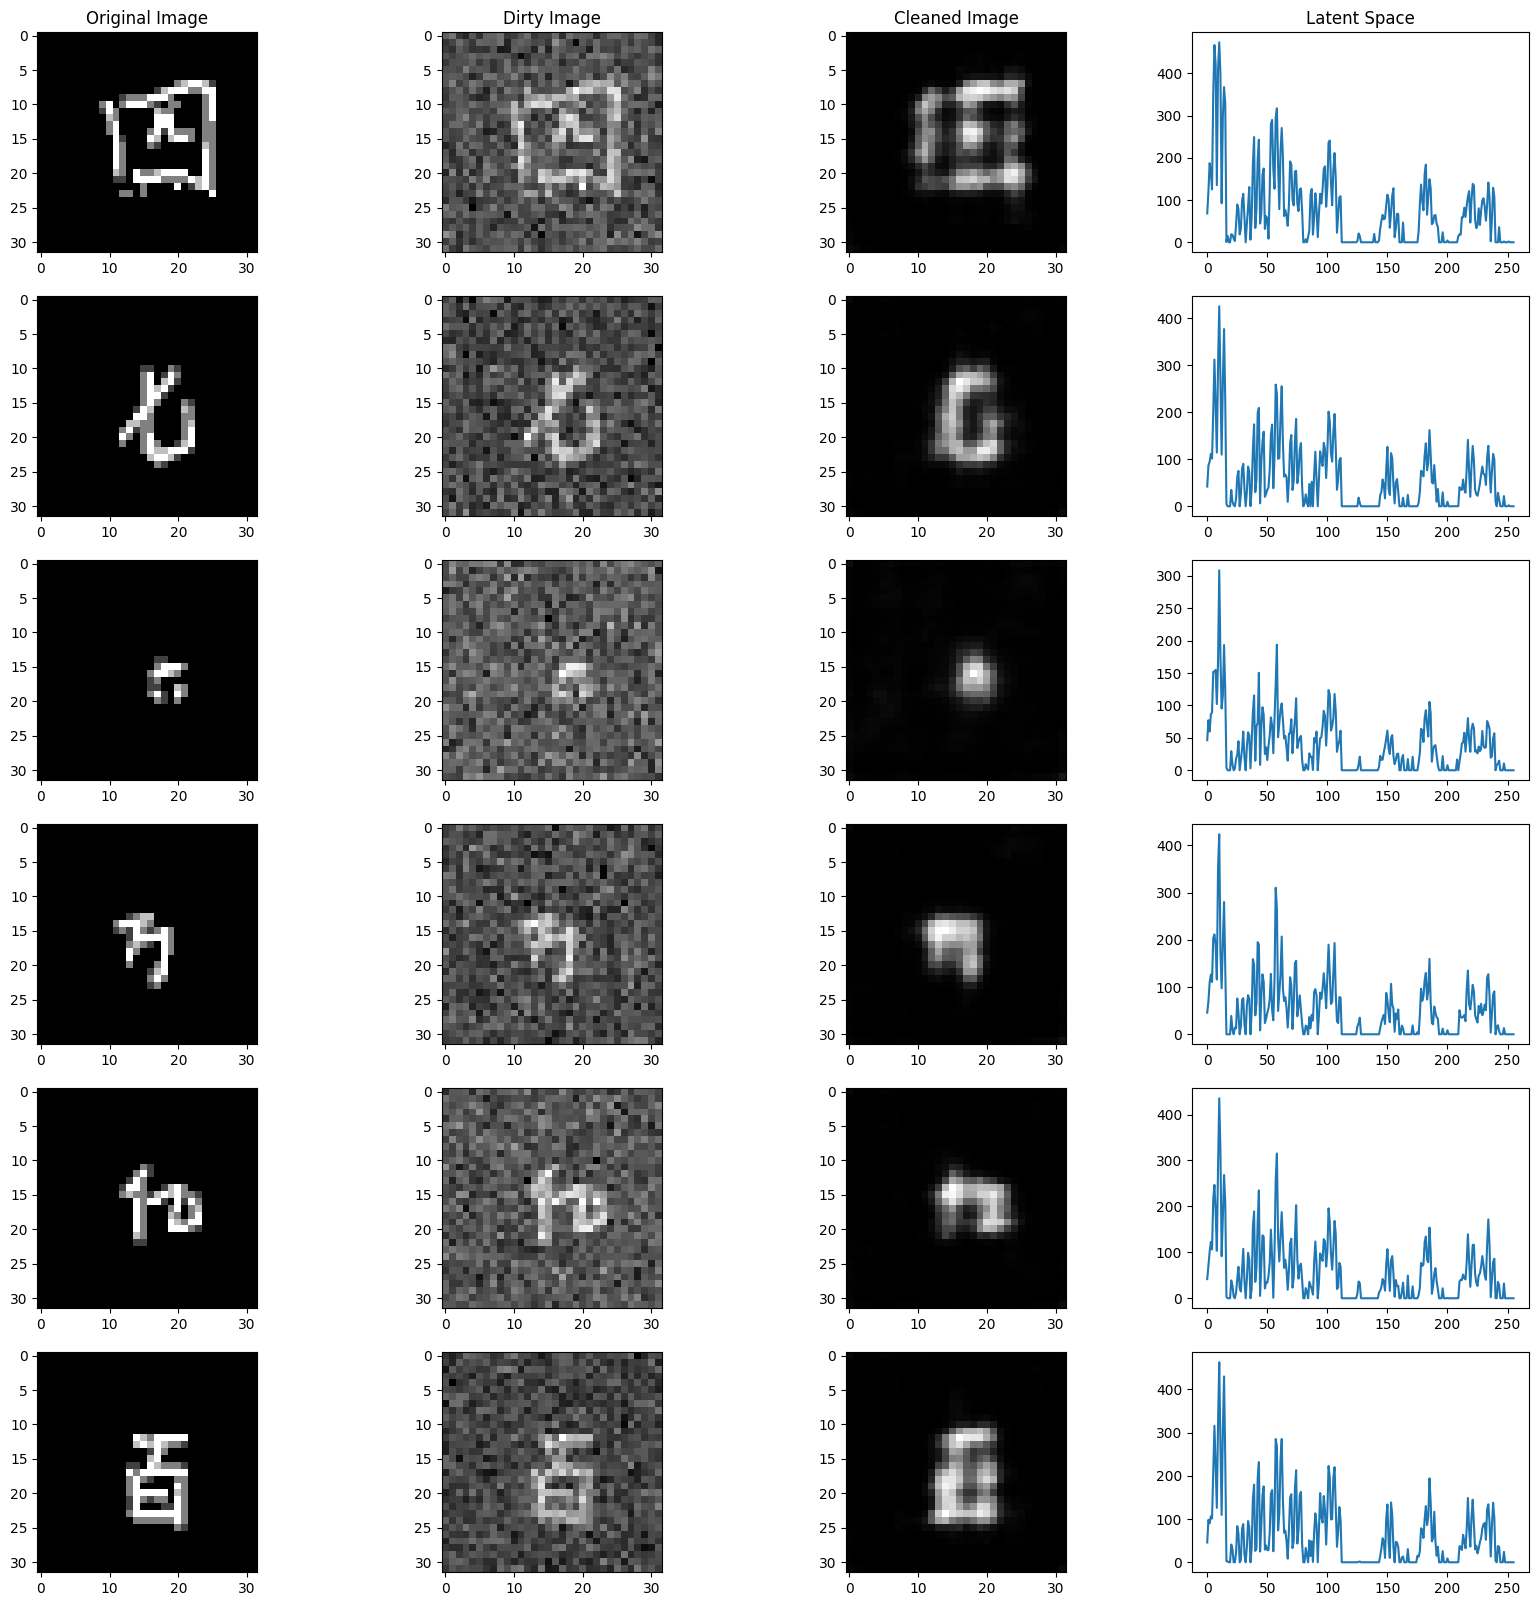

In [49]:
f, axes = plt.subplots(6, 4, figsize=(20, 20))
axes[0, 0].set_title("Original Image")
axes[0, 1].set_title("Dirty Image")
axes[0, 2].set_title("Cleaned Image")
axes[0, 3].set_title("Latent Space")

test_imgs = np.random.randint(0, 500, size=6)
for idx in range(6):
    dirty = testset[test_imgs[idx]][0]
    clean = testset[test_imgs[idx]][1]
    dirty = dirty.view(dirty.size(0), 1, 32, 32).type(torch.FloatTensor)
    dirty = dirty.to(device)
    output = model(dirty)
    output_encoder = model.encoderConv2D(dirty)

    output = output.view(1, 32, 32)
    output = output.permute(1, 2, 0).squeeze(2)
    output = output.detach().cpu().numpy()

    dirty = dirty.view(1, 32, 32)
    dirty = dirty.permute(1, 2, 0).squeeze(2)
    dirty = dirty.detach().cpu().numpy()

    clean = clean.permute(1, 2, 0).squeeze(2)
    clean = clean.detach().cpu().numpy()

    latent = output_encoder.detach().cpu().numpy()
    latent = latent.reshape(-1,)

    axes[idx, 0].imshow(clean, cmap="gray")
    axes[idx, 1].imshow(dirty, cmap="gray")
    axes[idx, 2].imshow(output, cmap="gray")
    axes[idx, 3].plot(latent)

plt.show()

In [67]:
SNRListe = []
PSNRListe = []

for dirty, clean in tqdm(testloader):
    dirty = dirty.view(1, 32, 32).type(torch.FloatTensor)
    dirty = dirty.to(device)
    output = model(dirty)

    output = output.detach().cpu().numpy()
    output = output.reshape(32,32)

    dirty = dirty.detach().cpu().numpy()
    dirty = dirty.reshape(32,32)

    print(dirty.max())

    clean = clean.detach().cpu().numpy()
    clean = clean.reshape(32,32)


    SNRListe.append(snr(dirty, clean))
    PSNRListe.append(snr(output, clean))

print(f"Moyenne SNR image bruitée : {np.mean(SNRListe)}")
print(f"Moyenne SNR image bruitée : {np.mean(PSNRListe)}")

  2%|▏         | 18/956 [00:00<00:11, 85.17it/s]

351.23795
388.95184
327.53033
363.4678
360.13834
324.03482
361.5186
358.52686
363.1513
360.2464
348.42282
373.22528
374.21735
336.5287
382.8878
271.96414
356.66748
332.67792


  3%|▎         | 28/956 [00:00<00:10, 91.23it/s]

355.0524
337.69034
358.0494
341.91312
366.4946
370.32675
347.2457
354.7576
315.80786
407.68503
364.84006
402.66125
355.80905
296.53943
329.88358
384.0072
300.56555
359.4004
395.54575


  5%|▌         | 48/956 [00:00<00:09, 92.46it/s]

387.32626
332.51212
338.29254
378.86584
362.69888
361.90643
336.99136
314.66544
362.04132
323.14313
391.61993
319.1668
353.51187
352.2785
360.21246
334.26495
290.87592
357.9526
314.13


  7%|▋         | 67/956 [00:00<00:10, 85.63it/s]

346.14648
366.35385
361.5144
374.69186
346.23364
363.61502
326.13293
369.45972
345.47153
348.15158
316.82275
317.48227
359.73712
343.1448
374.78946
348.21313
390.2724
350.61966
344.83713


  9%|▉         | 85/956 [00:00<00:10, 83.35it/s]

345.75787
336.30304
390.96844
350.84036
346.8521
312.21017
397.7458
366.2783
354.7775
332.88022
389.80215
338.158
321.88397
377.13293
359.0427
384.71194
361.98483


 11%|█         | 105/956 [00:01<00:09, 89.74it/s]

367.93805
356.2273
380.48608
329.70032
386.8876
350.45096
344.29794
382.91885
312.8564
322.07465
309.96432
342.2123
326.73105
377.56195
361.92038
348.13666
334.71085
328.40585
351.05658
301.34305
382.95078
387.10938


 13%|█▎        | 126/956 [00:01<00:08, 94.99it/s]

362.9668
374.74445
364.3665
349.07257
341.64023
379.98425
396.69983
339.49573
352.4194
337.8915
353.97888
346.21655
331.98837
346.42297
348.59683
344.42224
299.39417
372.56363
316.3393
355.0718


 15%|█▌        | 145/956 [00:01<00:09, 87.37it/s]

370.77652
321.3136
369.51956
310.9004
372.49747
413.60022
376.50983
435.67188
324.901
401.72784
325.05655
362.2837
372.73056
366.87927
369.04596
382.9173
316.12836
400.9869


 17%|█▋        | 166/956 [00:01<00:08, 92.81it/s]

373.7343
313.81952
393.72342
355.77075
367.3461
347.47614
323.775
330.33224
288.48734
290.867
356.02472
348.24268
354.14334
344.49713
308.03992
387.1501
342.24265
331.6129
283.32278
322.10855
333.9873
321.839


 20%|█▉        | 187/956 [00:02<00:07, 96.80it/s]

364.3997
360.25922
320.9232
358.50357
365.02014
305.15002
341.9894
336.98364
381.36932
333.30487
312.251
349.74597
384.7271
332.39383
348.35123
337.07944
352.4952
371.40933
344.0637
355.9091
362.70593


 22%|██▏       | 208/956 [00:02<00:07, 98.72it/s]

329.93253
324.88702
360.52234
318.6316
329.90753
365.27603
317.53915
366.07053
357.06573
379.99747
368.97842
315.233
339.50912
372.65643
355.5488
336.8024
332.34232
330.7236
343.3312
333.93652
312.0757
400.51566


 24%|██▍       | 229/956 [00:02<00:07, 98.87it/s]

366.31458
381.19144
374.55533
310.62494
317.85095
387.82135
340.1853
349.6725
323.48654
363.06522
367.33124
378.4187
313.73953
347.40555
426.29913
366.94382
292.26828
339.79764


 26%|██▌       | 249/956 [00:02<00:07, 94.55it/s]

358.87982
330.63055
407.5648
395.38956
367.88547
313.84048
334.92966
327.10815
374.1199
369.77313
349.85257
364.68695
361.17126
351.72333
388.54022
404.35367
349.3057
305.75006
342.26822
357.97787
373.9899


 29%|██▉       | 277/956 [00:02<00:07, 92.48it/s]

361.05405
384.8771
320.16107
374.05728
350.0278
296.7577
385.5052
351.85144
416.86664
340.0568
382.1702
287.25638
328.1268
364.301
396.54242
395.77078
371.05243
348.97537
351.6743
370.4921
331.02036


KeyboardInterrupt: 

In [40]:
PATH = "presentation/sinogrammeDense.pth"
torch.save(model.state_dict(), PATH)  # We save the model state dict at PATH